In [1]:
!pip install transformers datasets evaluate accelerate peft bitsandbytes
!pip install nvidia-ml-py3
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19191 sha256=49b94a9718bbeb03c62a0f74ccad8d19817f4d2ab833989b644afd480ec85e14
  Stored in directory: /home/to2226/.cache/pip/wheels/f6/d8/b0/15cfd7805d39250ac29318105f09b1750683387630d68423e1
Successfully built nvidia-ml-py3
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 1.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 8.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 53.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0

In [2]:
import os
import pandas as pd
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
import evaluate
from transformers import (
    RobertaTokenizer, RobertaModel, RobertaPreTrainedModel,
    RobertaForSequenceClassification, Trainer, TrainingArguments,
    DataCollatorWithPadding, AutoConfig
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, Dataset, ClassLabel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

/home/to2226/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class Config:
    base_model = "roberta-base"
    output_dir = "results_lora"
    use_fnn = False
    use_augmentation = False
    use_early_stopping = True
    use_weight_decay = False
    freeze_base_model = True
    use_mc_dropout_inference = False
    early_stopping_patience = 3
    weight_decay_value = 0.01
    mc_dropout_iterations = 10
    train_last_k_layers = 2
    max_seq_length = 256
    train_batch_size = 32
    eval_batch_size = 64
    num_train_epochs = 1
    learning_rate = 3e-6

    lora_r = 2
    lora_alpha = 4
    lora_dropout = 0.05
    lora_bias = "none"
    lora_target_modules = ["query", "value"]
    lora_task_type = "SEQ_CLS"

In [5]:
config = Config()

dataset = load_dataset("ag_news")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

tokenizer = RobertaTokenizer.from_pretrained(config.base_model)
tokenizer.model_max_length = config.max_seq_length

def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, max_length=config.max_seq_length, padding="max_length")

tokenized_train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["text"])

tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

Map: 100%|██████████| 7600/7600 [00:04<00:00, 1634.44 examples/s]


In [6]:
num_labels = len(set(tokenized_train_dataset["labels"]))

label_names = ["World", "Sports", "Business", "Sci/Tech"]

id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

print(f"Number of labels: {num_labels}")
print(f"Label names: {label_names}")

Number of labels: 4
Label names: ['World', 'Sports', 'Business', 'Sci/Tech']


In [7]:
model = RobertaForSequenceClassification.from_pretrained(
    config.base_model,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    target_modules=config.lora_target_modules,
    task_type=config.lora_task_type,
)

model = get_peft_model(model, lora_config)

def freeze_model_parameters(model):
    for name, param in model.named_parameters():
        if "lora" not in name and "classifier" not in name:
            param.requires_grad = False

if config.freeze_base_model:
    freeze_model_parameters(model)

model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 667,396 || all params: 125,316,104 || trainable%: 0.5326


In [8]:
def compute_metrics(p):
    metric = evaluate.load("accuracy")
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [9]:
training_args = TrainingArguments(
    output_dir=f'./trained_models/{config.output_dir}',
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=4000,
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.train_batch_size,
    per_device_eval_batch_size=config.eval_batch_size,
    num_train_epochs=config.num_train_epochs,
    weight_decay=config.weight_decay_value if config.use_weight_decay else 0.0,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    lr_scheduler_type="linear",
    warmup_ratio=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [10]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: to2226 (to2226-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
500,1.381900,1.377016,0.250000
1000,1.358700,1.357700,0.674211
1500,1.334600,1.334341,0.833158
2000,1.307200,1.304692,0.851447
2500,1.269400,1.272091,0.863158
3000,1.239200,1.244306,0.864211
3500,1.225700,1.228770,0.868947


TrainOutput(global_step=3750, training_loss=1.3069780202229817, metrics={'train_runtime': 1350.133, 'train_samples_per_second': 88.88, 'train_steps_per_second': 2.778, 'total_flos': 1.590996123648e+16, 'train_loss': 1.3069780202229817, 'epoch': 1.0})

In [11]:
model.save_pretrained(f'./trained_models/{config.output_dir}/final_model')
tokenizer.save_pretrained(f'./trained_models/{config.output_dir}/final_model')

('./trained_models/results_lora/final_model/tokenizer_config.json',
 './trained_models/results_lora/final_model/special_tokens_map.json',
 './trained_models/results_lora/final_model/vocab.json',
 './trained_models/results_lora/final_model/merges.txt',
 './trained_models/results_lora/final_model/added_tokens.json')

In [12]:
# Extract metrics from trainer.state.log_history
history = trainer.state.log_history

steps = []
train_losses = []
val_losses = []
val_accuracies = []

for record in history:
    if 'loss' in record and 'step' in record:
        train_losses.append(record['loss'])
        steps.append(record['step'])
    if 'eval_loss' in record:
        val_losses.append(record['eval_loss'])
    if 'eval_accuracy' in record:
        val_accuracies.append(record['eval_accuracy'])

import numpy as np
steps = np.array(steps)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

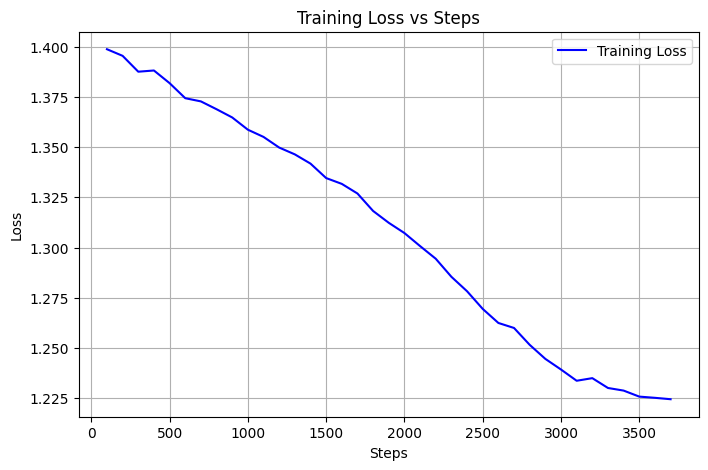

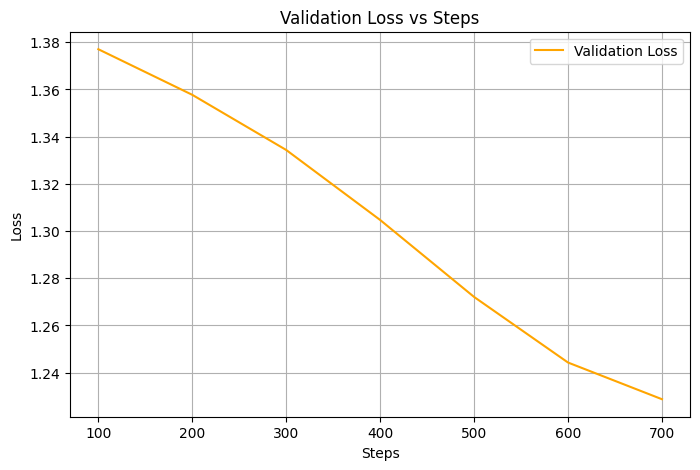

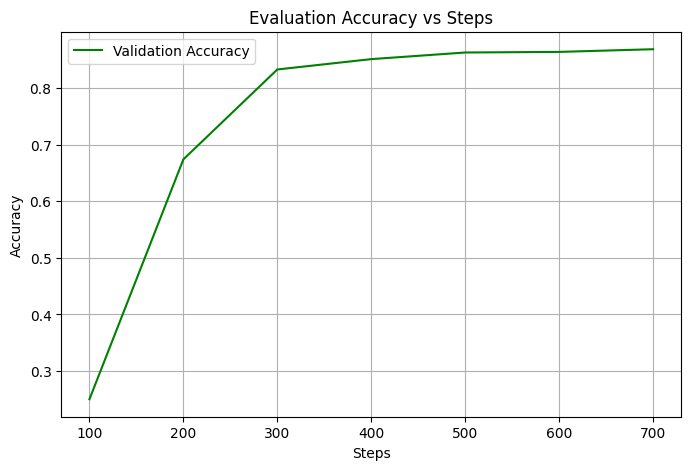

In [18]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(8,5))
plt.plot(steps, train_losses, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8,5))
plt.plot(steps[:len(val_losses)], val_losses, label="Validation Loss", color="orange")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss vs Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(steps[:len(val_accuracies)], val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy vs Steps")
plt.legend()
plt.grid(True)
plt.show()

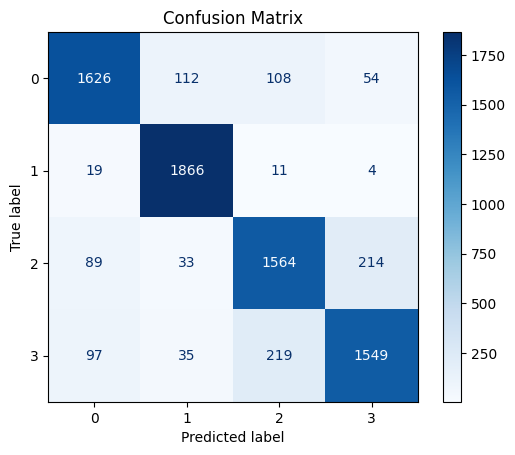

In [13]:
predictions = trainer.predict(tokenized_test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [14]:
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        preds = outputs.logits.argmax(dim=1)
        all_predictions.append(preds.cpu())

        if labelled:
            metric.add_batch(
                predictions=preds.cpu().numpy(),
                references=batch["labels"].cpu().numpy()
            )

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        final_metric = metric.compute()
        print(f"Evaluation Accuracy: {final_metric['accuracy']}")
        return final_metric, all_predictions
    else:
        return all_predictions

In [15]:
eval_metric, _ = evaluate_model(model, tokenized_test_dataset, labelled=True, batch_size=config.eval_batch_size, data_collator=data_collator)

Evaluating: 100%|██████████| 119/119 [00:30<00:00,  3.93it/s]


Evaluation Accuracy: 0.8690789473684211


In [17]:
with open("test_unlabelled.pkl 2", "rb") as f:
    custom_test_dataset = pickle.load(f)

tokenizer.model_max_length = 256

def preprocess_test(examples):
    return tokenizer(examples["text"], truncation=True, max_length=256, padding="max_length")

tokenized_custom_test_dataset = custom_test_dataset.map(preprocess_test, batched=True, remove_columns=["text"])

test_dataloader = DataLoader(tokenized_custom_test_dataset, batch_size=config.eval_batch_size, collate_fn=data_collator)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_predictions = []

for batch in tqdm(test_dataloader, desc="Generating Predictions"):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        preds = outputs.logits.argmax(dim=1)
        all_predictions.append(preds.cpu())

predicted_labels = torch.cat(all_predictions, dim=0).numpy()

ids = list(range(len(custom_test_dataset)))
output_df = pd.DataFrame({"ID": ids, "Label": predicted_labels})
output_df.to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")

Generating Predictions: 100%|██████████| 125/125 [00:31<00:00,  3.94it/s]

Predictions saved to predictions.csv
